<a href="https://colab.research.google.com/github/bbRLdev/Modular-Reinforcement-Learning/blob/main/modular_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import random 
import time
import numpy as np 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm

SIDEWALK_LENGTH = 8 * 25 # 8 rows, 25 cols
LITTER_CHANCE = .2
WALL_CHANCE = .2
NUM_ACTIONS = 4

FORWARD = 0
UP = 1
DOWN = 2
BACKWARDS = 3

NORMAL = "N"
OBSTACLE = "O"
LITTER = "L"

# World Rules

In [ ]:
def get_litter_and_obstacles():
  all_litter, all_obstacles = [], []
  for tile in range(SIDEWALK_LENGTH):
    litter_decision = random.random()
    wall_decision = random.random()
    if LITTER_CHANCE > litter_decision:
      all_litter.append(tile)
    elif WALL_CHANCE > wall_decision:
      all_obstacles.append(tile)
  return all_litter, all_obstacles
def gen_world():
  world = [NORMAL for _ in range(SIDEWALK_LENGTH)]
  for i in range(len(world)):
    litter_decision = random.random()
    wall_decision = random.random()
    if LITTER_CHANCE > litter_decision:
      world[i] = LITTER
    elif WALL_CHANCE > wall_decision:
      world[i] = OBSTACLE
  return world
def move(state, action):
  row, col = state
  if action == 0: # right
    col += 1
  elif action == 1: # up
    row -= 1
  elif action == 2: # down
    row += 1
  elif action == 3: # left
    col -= 1
  return row, col

def get_legal_moves(state, sidewalk):
  cur_row, cur_col = state
  num_rows, num_cols = sidewalk.shape
  legal_moves = []
  for i in range(4):
    row, col = move(state, i)
    if row >= 0 and row < num_rows and col >= 0 and col < num_cols:
      legal_moves.append(i)
  return legal_moves

def state_to_coordinate(sidewalk, state):
  return (int(state / sidewalk.shape[1]), state % sidewalk.shape[1])
def manhattan_dist(state1, state2):
  return abs(state1[0]-state2[0]) + abs(state1[1]-state2[1])
def coordinate_to_state(sidewalk, coordinate):
  x, y = coordinate
  return int(x * sidewalk.shape[1] + y)

# Q-Learning Methods

In [ ]:
def get_q_val_from_action(state, actions, q_table):
    q_vals = []
    sidewalk = center_module_world()
    state_idx = coordinate_to_state(sidewalk, state)
    for action in actions:
        q_vals.append(q_table[state_idx, action])
    return q_vals

def steps(exploration_rate, sidewalk, state, q_table, food_reward=None):
  exploration_rate_threshold = random.uniform(0, 1)
  legal_moves = get_legal_moves(state, sidewalk)
  # Exploitation
  if exploration_rate_threshold > exploration_rate: 
    q_vals = get_q_val_from_action(state, legal_moves, q_table)
    action = legal_moves[np.argmax(q_vals)]
  # Exploration
  else: 
    action_idx = random.randint(0, len(legal_moves)-1)
    action = legal_moves[action_idx]
  new_state = move(state, action)
  return new_state, action

def do_q_learning(num_trials, max_steps, learning_rate, discount_rate, explore_rate, max_explore_rate, min_explore_rate, explore_decay_rate, q_table, sidewalk, modules, food_reward=None):
  rewards_all_trials = []
  sidewalk_copy = np.copy(sidewalk)
  for trial in tqdm(range(num_trials)):
      done = False
      reward_current_trial = 0
      store_state = []
      step = 0
      state = (3,0)
      if(food_reward != None):
        sidewalk = sidewalk_copy
      while not done and step < max_steps: 
        new_state, action = steps(explore_rate, sidewalk, state, q_table, food_reward)
        reward = 0
        for module in modules:
          reward += module.get_reward(new_state, action)
        state_idx = coordinate_to_state(sidewalk, state)
        new_state_idx = coordinate_to_state(sidewalk, new_state)
        q_table[state_idx, action] = q_table[state_idx, action] * (1 - learning_rate) + learning_rate * (reward + discount_rate * np.max(q_table[new_state_idx, :]))
        state = new_state
        reward_current_trial += reward 
        store_state.append(new_state_idx)  
        if new_state[1] == 24:
          done = True 
        step += 1
      # Exploration rate decay
      explore_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
      rewards_all_trials.append(reward_current_trial)
      for module in modules:
        module.refresh()
  return rewards_all_trials, q_table, store_state

def make_q_table(size, num_directions):
  q_table = np.zeros([size, num_directions])
  q_table[0:25, 1:2] = np.NINF
  q_table[175:200, 2:3] = np.NINF
  q_table[0:176:25, 3:] = np.NINF
  q_table[24:200:25, 0:1] = np.NINF
  return q_table

# Visualization

In [ ]:

def draw_grid(img, grid_shape, width, color=(0, 255, 0)):
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols
    print(img.shape)
    # draw vertical lines
    cv2.rectangle(img, (0, width), (img.shape[1], img.shape[0]-width), (105, 105, 105), -1)
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv2.line(img, (x, 0), (x, h), color=color, thickness=1)
    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv2.line(img, (0, y), (w, y), color=color, thickness=1)
          # Python program to explain cv2.circle() method
    return img
def draw_circle(img, states, width, sidewalk):
  for state in states:
    row, col = state_to_coordinate(sidewalk, state)
    circle_center = (col * width + int(width/2), row * width + int(width/2))
    cv2.circle(img, circle_center, int(width/2)-2, (0,0,255), 2)
  return img
def draw_litter_and_obstacles(img, width, sidewalk, litter, obstacles):
  for trash in litter:
    row, col = state_to_coordinate(sidewalk, trash)
    cv2.rectangle(img, (col*width+20, row*width+20), (col*width+width-20, row*width+width-20), (128, 0, 128), -1)
  for obstacle in obstacles:
    row, col = state_to_coordinate(sidewalk, obstacle)
    cv2.rectangle(img, (col*width+20, row*width+20), (col*width+width-20, row*width+width-20), (255, 0, 0), -1)
  return img
def draw_rewards(img, width, sidewalk):
  fontScale = 1
  color = (255, 255, 255)
  font = cv2.FONT_HERSHEY_COMPLEX_SMALL
  thickness = 1
  for i in range((sidewalk.shape[0]*sidewalk.shape[1])):
    row, col = state_to_coordinate(sidewalk, i)
    text = str(sidewalk[row][col])
    org = (int(col*width+width/4), int(row*width+width/2))
    # Using cv2.putText() method
    cv2.putText(img, text, org, font, fontScale, 
                    color, thickness, cv2.LINE_AA, False)
  return img
def show_sidewalk(sidewalk, states, litter, obstacles, width=100):
  rows, cols = sidewalk.shape
  canvas = np.zeros((rows*width, cols*width, 3), dtype="uint8")
  # draw a green line from the top-left corner of our canvas to the
  # bottom-right
  cv2.waitKey(0)
  canvas = draw_grid(canvas, (len(sidewalk), len(sidewalk[0])), width)
  canvas = draw_circle(canvas, states, width, sidewalk)
  canvas = draw_litter_and_obstacles(canvas, width, sidewalk, litter, obstacles)
  # canvas = draw_rewards(canvas, width, sidewalk)
  cv2_imshow(canvas)
  cv2.waitKey(0)

# Module Classes

In [ ]:
class RL_Module():
  def __init__(self, world):
    self.world = world
  def refresh(self):
    pass
    
class Center_Module(RL_Module):
  def __init__(self, world, reward, penalty):
    super().__init__(world)
    self.reward = reward
    self.penalty = penalty
  def get_reward(self, state, action):
    row, col = state
    if row == 0 or row == len(world) - 1:
      return self.penalty
    else:
      return self.reward

class Litter_Module(RL_Module):
  def __init__(self, world, reward, penalty):
    super().__init__(world)
    self.reward = reward
    self.penalty = penalty
    self.litter_map = world
  def get_reward(self, state, action):
    sidewalk = center_module_world()
    state_idx = coordinate_to_state(sidewalk, state)
    val = self.reward
    if world[state_idx] != LITTER:
      val = self.penalty
    else:
      self.litter_map[state_idx] = NORMAL
    return val
  def refresh(self):
    self.liter_map = self.world

class Obstacle_Module(RL_Module):
    def __init__(self, world, penalty):
        super().__init__(world)
        self.penalty = penalty
    def get_reward(self, state, action):
        sidewalk = center_module_world()
        state_idx = coordinate_to_state(sidewalk, state)
        if self.world[state_idx] == OBSTACLE:
            return self.penalty
        else:
            return 0  
class Forward_Module(RL_Module):
    def __init__(self, world, back_penalty, side_penalty, reward):
        super().__init__(world)
        self.back_penalty = back_penalty
        self.side_penalty = side_penalty
        self.reward = reward
    def get_reward(self, state, action):
        if action == FORWARD:
            return self.reward
        if action == BACKWARDS:
            return self.back_penalty
        else:
            return self.side_penalty

# Center Module

In [ ]:
def center_module_world(center_reward=0.0, penalty=-1.0):
  state = np.zeros(SIDEWALK_LENGTH)
  state = np.reshape(state, (8, 25))
  num_rows = int(state.shape[0])
  num_cols = int(state.shape[1])
  state[1:-1] = center_reward
  state[0][:] = penalty
  state[-1][:] = penalty
  return state

In [ ]:

# # Place Litter and Walls
# total_trials = 5
# max_steps_per_episode = 100

# learning_rate = 1.0
# discount_rate = 0.0

# # exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
# exploration_rate =  1.0
# max_exploration_rate = 1.0
# min_exploration_rate = 0.001
# exploration_decay_rate = 0.05

# actions = 4

# # Make Qmap
# q_table_center = make_q_table(200, 4)
# sidewalk = center_module_world(center_reward=3.0, penalty = -100.0)
# rewards, q_table_center, path = do_q_learning(
#     total_trials, 
#     max_steps_per_episode, 
#     learning_rate, 
#     discount_rate, 
#     exploration_rate, 
#     max_exploration_rate,
#     min_exploration_rate, 
#     exploration_decay_rate, 
#     q_table_center,
#     sidewalk)
# show_sidewalk(sidewalk, path, [], [])
# print(rewards[-1])
# print(state_to_coordinate(sidewalk, path[-1]))
# print(state_to_coordinate(sidewalk, path[-2]))
# print(path)

['N', 'N', 'N', 'N', 'N', 'O', 'N', 'N', 'L', 'O', 'N', 'L', 'N', 'N', 'O', 'N', 'L', 'L', 'O', 'N', 'O', 'N', 'N', 'O', 'L', 'N', 'N', 'N', 'L', 'N', 'N', 'O', 'N', 'N', 'N', 'O', 'N', 'N', 'L', 'N', 'O', 'L', 'L', 'N', 'N', 'N', 'O', 'N', 'O', 'N', 'N', 'O', 'N', 'N', 'N', 'N', 'N', 'N', 'O', 'O', 'N', 'N', 'O', 'N', 'N', 'L', 'N', 'O', 'L', 'L', 'N', 'N', 'O', 'N', 'N', 'N', 'N', 'L', 'L', 'N', 'N', 'N', 'N', 'N', 'N', 'L', 'L', 'N', 'N', 'N', 'L', 'N', 'N', 'L', 'L', 'L', 'L', 'N', 'N', 'L', 'N', 'L', 'N', 'N', 'O', 'O', 'O', 'N', 'L', 'O', 'L', 'L', 'N', 'O', 'L', 'N', 'O', 'L', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'L', 'L', 'N', 'L', 'N', 'N', 'N', 'N', 'O', 'L', 'N', 'N', 'N', 'N', 'L', 'L', 'N', 'N', 'L', 'N', 'N', 'N', 'N', 'N', 'O', 'O', 'N', 'N', 'L', 'N', 'N', 'N', 'L', 'O', 'N', 'N', 'N', 'N', 'N', 'N', 'L', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'L', 'N', 'N', 'O', 'O', 'N', 'L', 'N', 'N', 'N', 'N', 'O', 'L', 'N', 'O', 'L', 'N', 'L', 'N', 'L', 'N', 'N', 'N', 'O', 'N', 'O', 'N']

  0%|          | 0/1000 [00:00<?, ?it/s]

(800, 2500, 3)


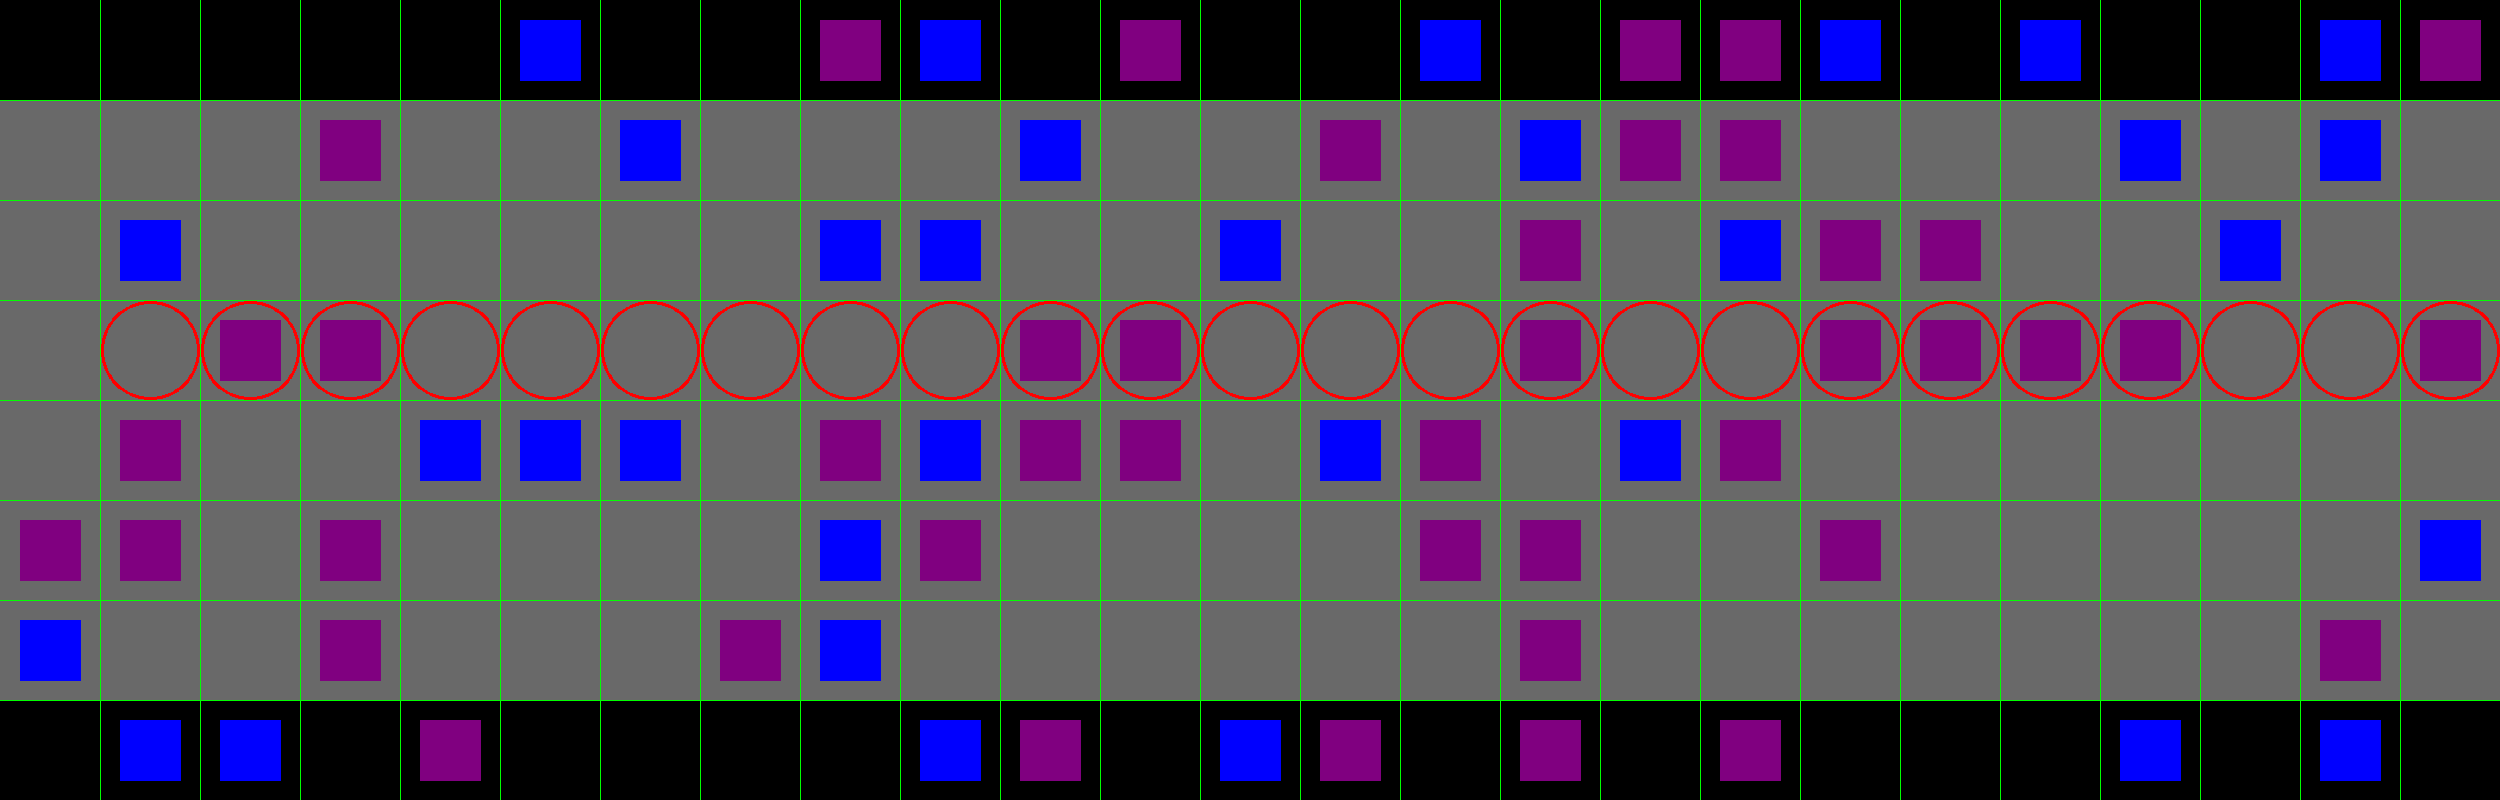

14.399999999999995
(3, 24)
(3, 23)
[76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


In [ ]:
world = gen_world()
print(world)
litter = [index for index, element in enumerate(world) if element == LITTER]
obstacles = [index for index, element in enumerate(world) if element == OBSTACLE]
forward_module = Forward_Module(world, -1.0, 0.0, 1.0)
obstacle_module = Obstacle_Module(world, -10.0)
litter_module = Litter_Module(world, 10.0, -0.5)
center_module = Center_Module(world, 0.1, -100.0)
# Place Litter and Walls
total_trials = 1000
max_steps_per_episode = 100

learning_rate = 1.0
discount_rate = 0.0

# exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
exploration_rate =  1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.001
exploration_decay_rate = 0.05

actions = 4
modules = [obstacle_module, litter_module, center_module, forward_module]
# Make Qmap
q_table = make_q_table(200, 4)
sidewalk = center_module_world(center_reward=3.0, penalty = -100.0)
rewards, q_table, path = do_q_learning(
    total_trials, 
    max_steps_per_episode, 
    learning_rate, 
    discount_rate, 
    exploration_rate, 
    max_exploration_rate,
    min_exploration_rate, 
    exploration_decay_rate, 
    q_table,
    sidewalk,
    modules)
show_sidewalk(sidewalk, path, litter, obstacles)
print(rewards[-1])
print(state_to_coordinate(sidewalk, path[-1]))
print(state_to_coordinate(sidewalk, path[-2]))
print(path)

# Move Forward Module

In [ ]:
def forward_module_world():
  state = np.zeros(SIDEWALK_LENGTH)
  state = np.reshape(state, (8, 25))
  state[:] = np.linspace(0, 3, 25)
  print(state)
  return state

In [ ]:

total_trials = 100
max_steps_per_episode = 100

learning_rate = 1.0 
discount_rate = 0.0

# exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
exploration_rate =  1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.001
exploration_decay_rate = 0.05

actions = 4

# Make Qmap
q_table_forward = make_q_table(200, 4)
sidewalk = forward_module_world()
rewards, q_table_forward, path = do_q_learning(
    total_trials, 
    max_steps_per_episode, 
    learning_rate, 
    discount_rate, 
    exploration_rate, 
    max_exploration_rate,
    min_exploration_rate, 
    exploration_decay_rate, 
    q_table_center,
    sidewalk)
trash, obstacles = get_litter_and_obstacles()
show_sidewalk(sidewalk, path, trash, obstacles)

# Obstacle Module

In [ ]:
def obstacle_module_world(penalty, obstacles):
  state = np.zeros(SIDEWALK_LENGTH)
  state[:] = 0.1
  state = np.reshape(state, (8, 25))
  for obstacle in obstacles:
    row, col = state_to_coordinate(sidewalk, obstacle)
    state[row][col] = penalty
  return state

In [ ]:
total_trials = 10000
max_steps_per_episode = 100

learning_rate = 1.0 
discount_rate = 0.5

# exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
exploration_rate =  1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.001
exploration_decay_rate = 0.05
trash, obstacles = get_litter_and_obstacles()

actions = 4
# Make Qmap
q_table_obstacle = make_q_table(200, 4)
sidewalk = obstacle_module_world(-10.0, obstacles)
rewards, q_table_obstacle, path = do_q_learning(
    total_trials, 
    max_steps_per_episode, 
    learning_rate, 
    discount_rate, 
    exploration_rate, 
    max_exploration_rate,
    min_exploration_rate, 
    exploration_decay_rate, 
    q_table_center,
    sidewalk)
show_sidewalk(sidewalk, path, trash, obstacles)
len(path)
print(rewards[-1])

# Litter module

In [ ]:
def litter_module_world(reward, flat_value, litter):
  state = np.zeros(SIDEWALK_LENGTH)
  state[:] = flat_value
  state = np.reshape(state, (8, 25))
  for trash in litter:
    row, col = state_to_coordinate(sidewalk, trash)
    state[row][col] = reward
  return state

In [ ]:
total_trials = 1
max_steps_per_episode = 1000000

learning_rate = 1.0 
discount_rate = 0.2

# exploration_rate = min_explore_rate + (max_explore_rate - min_explore_rate) * np.exp(-explore_decay_rate*trial)
exploration_rate =  1.0
max_exploration_rate = 1.0
min_exploration_rate = 0.001
exploration_decay_rate = 0.001
trash, obstacles = get_litter_and_obstacles()

actions = 4
# Make Qmap
q_table_obstacle = make_q_table(200, 4)
food_reward = 10.0
sidewalk = litter_module_world(food_reward,0.0, trash)
rewards, q_table_obstacle, path = do_q_learning(
    total_trials, 
    max_steps_per_episode, 
    learning_rate, 
    discount_rate, 
    exploration_rate, 
    max_exploration_rate,
    min_exploration_rate, 
    exploration_decay_rate, 
    q_table_center,
    sidewalk,
    food_reward)
show_sidewalk(sidewalk, path, trash, [])
print(rewards[-1])